# Connecticut River plume signature in the Coastal Pioneer Array from annual peak discharge, 2017
Looking at the Inshore Surface Mooring (**CP03ISSM**), the Central Surface Mooring (**CP01CNSM**), and the Offshore Surface Mooring (**CP04OSSM**). Using the Bulk Meteorology Package (METBK) to try to corroborate each other and track the surface salinity. Cruise data is available as well. 

Possibly corroborate other Connecticut River Plume data from NASA MODIS satellite data, OOI Cruise data, and/or from Mike Whitney, UConn (?). 


---


Molly James, University of Connecticut (molly.james@uconn.edu)

OOI Data Workshop - Physics

May 21-25, 2018

# Starting to look at the data 
| Site | Instrument | Deployment | Reference Designator | Method | Stream 
| -- | -- | -- | -- | -- | --
| Inshore  | METBK | 5 | [CP03ISSM-SBD11-06-METBKA000](https://ooinet.oceanobservatories.org/data_access/?search=CP03ISSM-SBD11-06-METBKA000) | recovered_host | metbk_a_dcl_instrument
| Central | METBK | 6 & 7  |[CP01CNSM-SBD12-06-METBKA000](https://ooinet.oceanobservatories.org/data_access/?search=CP01CNSM-SBD12-06-METBKA000) | recovered_host | metbk_a_dcl_instrument |
| Offshore | METBK | 5 & 6 | [CP04OSSM-SBD11-06-METBKA000](https://ooinet.oceanobservatories.org/data_access/?search=CP04OSSM-SBD11-06-METBKA000) | recovered_host | metbk_a_dcl_instrument

In [0]:
## Using the API to navigate the data available from CP03ISPM

# First, let's import the Python libraries we will need
import requests
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os

In [0]:
# API Information
USERNAME =''
TOKEN= ''
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv' # used to get metadata
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'  # annotations API url


In [0]:
# Instrument Information
site1 = 'CP03ISSM' # inshore surface mooring
site2 = 'CP01CNSM' # central surface mooring
site3 = 'CP04OSSM' # offshore surface mooring
node  = 'SBD11'
node2 = 'SBD12'
instrument = '06-METBKA000'
method = 'recovered_host'              # need to have the underscore not a dash!
stream = 'metbk_a_dcl_instrument_recovered'

## Time of interest
Time period of interest is the peak discharge of the Connecticut River in the spring. This is usually in April when the snow melts in the watershed, therefore, to get a window of data is good, so March to May. 

Only going to consider the data from Spring 2017.
* Inshore Surface
* Central Surface
  * two options for METBK instruments 
* Offshore Surface
* MODIS Satellite Ocean Color 
* Cruise Data?
  * Need to see timing of cruises for deployments

In [0]:
# importing new libraries
!pip install netCDF4
import netCDF4 as nc

!pip install xarray
import xarray as xr

!pip install cmocean
import cmocean


In [0]:
# request to see the timing of the deployments, when time periods we want to look at
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

In [0]:
# Setup the API request url
# to check the time period of the deployment

ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'           # calibration/deployment Info
data_request_url = ASSET_API + '/events/deployment/query'
params = {                                  # checking if available for spring 2018
  'beginDT':'2017-03-01T00:00:00.000Z', 
  'endDT':'2017-06-01T00:00:00.000Z',
  'refdes':site1+'-'+node+'-'+instrument,   # change site between site1, site2, site3
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

asset_id  deployment  latitude  longitude              sensor  \
0     284.0         5.0  40.36192  -70.87827  CGINS-METLGR-00012   

                start                stop  
0 2016-10-11 13:39:00 2017-06-15 15:56:00

## Inshore Surface Mooring CP03ISSM

Asynchronous requesting the NetCDF files to get the whole data set telemetered because not recovered yet

In [0]:
beginDT = '2017-03-01T00:00:00.000Z'
endDT = '2017-06-01T00:00:00.000Z'

DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv' # used to get data


In [0]:
# Inshore Surface Mooring 
# DO NOT RERUN B/C ALREADY REQUESTED
#data_request_url ='/'.join((DATA_API,site1,node,instrument,method,stream))
#params = {
#    'beginDT':beginDT,
#    'endDT':endDT,   
#}
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()


In [0]:
#data


In [0]:
#whos # lets you see your variable space

In [0]:
#%%time
#check_complete = data['allURLs'][1] + '/status.txt'
#for i in range(1800): 
#    r = requests.get(check_complete)
#    if r.status_code == requests.codes.ok:
#        print('request completed')
#        break
#    else:
#        time.sleep(1)

In [0]:
#data['allURLs'][0]

In [0]:
#Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T140008-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets1 = [os.path.join(tds_url, i) for i in x]
datasets1

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T140008-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170301T000032.626000-20170531T235954.139000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T140008-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CP03ISSM-RID26-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20170301T000008-20170531T234516.nc']

In [0]:
# remove the VELPT (point velocity instrument) data from datasets that was added???


In [0]:
!pip install dask

In [0]:
# Load all files into a single xarray dataset.
# xarray is for the geosciences community. uses pandas, numpy, and math libraries under the hood. and understands the netCDF file formats.
data_url1 = datasets1[0]
data_url1

u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T140008-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170301T000032.626000-20170531T235954.139000.nc'

In [0]:
# Open the dataset
ds_issm = xr.open_dataset(data_url1)

# Swap the dimensions
ds_issm = ds_issm.swap_dims({'obs': 'time'})
ds_issm

<xarray.Dataset>
Dimensions:                               (time: 132121)
Coordinates:
    obs                                   (time) int32 0 1 2 3 4 5 6 7 8 9 ...
  * time                                  (time) datetime64[ns] 2017-03-01T00:00:32.625999872 ...
    lat                                   (time) float64 ...
    lon                                   (time) float64 ...
Data variables:
    deployment                            (time) int32 ...
    id                                    (time) |S64 ...
    air_temperature                       (time) float32 ...
    barometric_pressure                   (time) float32 ...
    dcl_controller_timestamp              (time) object ...
    driver_timestamp                      (time) datetime64[ns] ...
    eastward_wind_velocity                (time) float32 ...
    ingestion_timestamp                   (time) datetime64[ns] ...
    internal_timestamp                    (time) datetime64[ns] ...
    longwave_irradiance           

In [0]:
print(ds_issm.geospatial_lat_max)
print(ds_issm.geospatial_lon_max)

40.36192
-70.87827


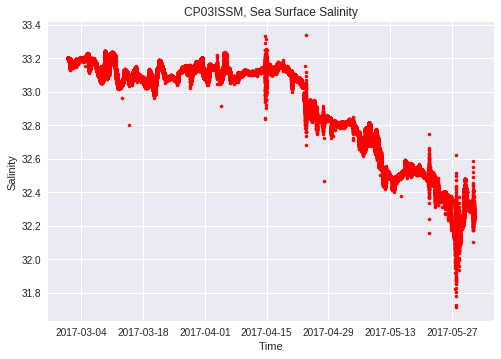

In [0]:
# plotting?
## my attempt at plotting

plt.plot(ds_issm['time'],ds_issm['met_salsurf'],'r.')
plt.title('CP03ISSM, Sea Surface Salinity')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.show()

![alt text](https://nadww01.er.usgs.gov/nwisweb/data/img/USGS.01184000.66838.00060..20170301.20170601.log.0.p50.pres.gif)

This is the peak discharge time period for the Connecticut River. There will be a delay in the response of the ocean. It makes sense that the salinity would decrease after around April 15th (which it does in the above salinity plot)

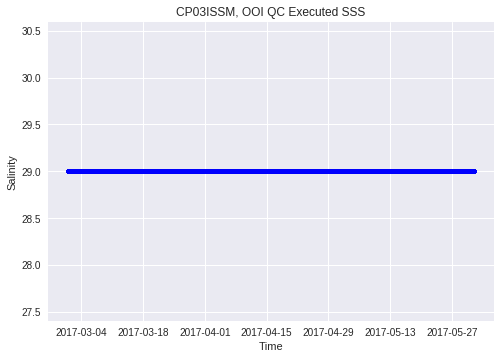

In [0]:

plt.plot(ds_issm['time'],ds_issm['met_salsurf_qc_executed'],'b.')

plt.title('CP03ISSM, OOI QC Executed SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')

plt.show()

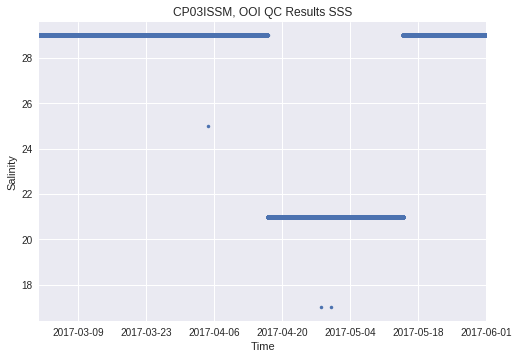

In [0]:
plt.plot(ds_issm['time'],ds_issm['met_salsurf_qc_results'],'.')

plt.title('CP03ISSM, OOI QC Results SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.xlim(['2017-03-01T00:00:00.000Z','2017-06-01T00:00:00.000Z'])

plt.show()

## Central Surface Mooring CP01CNSM
going to get a larger time window to show the movement of the plume to the shelf.


In [0]:
beginDT = '2017-02-01T00:00:00.000Z'
endDT = '2017-09-01T00:00:00.000Z'
#Larger time period 


In [0]:
data_request_url = ASSET_API + '/events/deployment/query'
params = {                                   # checking if available for spring 2018
  'beginDT':beginDT, 
  'endDT':endDT,
  'refdes':site2+'-'+node2+'-'+instrument,   # change site between site1, site2, site3
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

asset_id  deployment   latitude  longitude              sensor  \
0     313.0         6.0  40.133420  -70.77847  CGINS-METLGR-00031   
1     146.0         7.0  40.139817  -70.77115  CGINS-METLGR-00007   

                start                stop  
0 2016-10-13 18:36:00 2017-06-09 16:05:00  
1 2017-06-09 14:24:00 2017-11-01 20:33:00

In [0]:
# Central Surface Mooring, site2 and node2 (more data at node2)
# DO NOT RERUN B/C ALREADY REQUESTED

#data_request_url ='/'.join((DATA_API,site2,node2,instrument,method,stream))
#params = {
#    'beginDT':beginDT,
#    'endDT':endDT,   
#}
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()


In [0]:
#data

In [0]:
#data['allURLs'][0]

In [0]:
#Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets2 = [os.path.join(tds_url, i) for i in x]
datasets2

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0007_CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170609T142445.583000-20170831T235925.584000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0007_CP01CNSM-RID26-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20170609T143000-20170901T000000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170201T000059.314000-20170609T095244.332000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly

In [0]:
# only looking at the METBK package not the VELPT
data_url2 = datasets2[0],datasets2[2]
data_url2

(u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0007_CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170609T142445.583000-20170831T235925.584000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T150109-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170201T000059.314000-20170609T095244.332000.nc')

In [0]:
#Load all files into a single xarray dataset.

ds_cnsm = xr.open_mfdataset(data_url2)
ds_cnsm = ds_cnsm.swap_dims({'obs': 'time'})
ds_cnsm = ds_cnsm.chunk({'time': 100})
ds_cnsm = ds_cnsm.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds_cnsm

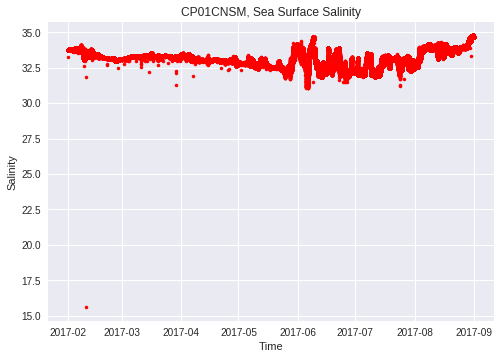

In [0]:

plt.plot(ds_cnsm['time'],ds_cnsm['met_salsurf'],'r.')
plt.title('CP01CNSM, Sea Surface Salinity')
plt.ylabel('Salinity')
plt.xlabel('Time')
#plt.xlim(['2017-05-14T00:00:00.000Z','2017-06-15T00:00:00.000Z'])
plt.show()


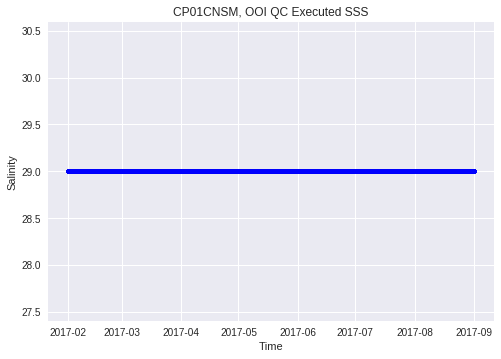

In [0]:

plt.plot(ds_cnsm['time'],ds_cnsm['met_salsurf_qc_executed'],'b.')

plt.title('CP01CNSM, OOI QC Executed SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.show()

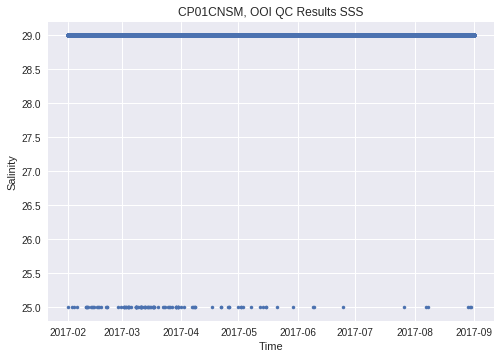

In [0]:
plt.plot(ds_cnsm['time'],ds_cnsm['met_salsurf_qc_results'],'.')

plt.title('CP01CNSM, OOI QC Results SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.show()
#this doesn't look right either...

Some strangeness with the QC results, scattered low salinity things that aren't in a pattern

## Offshore Surface Mooring CP04OSSM
Now to check if the salinity is affected by the plume this far out onto the shelf.

In [0]:
beginDT = '2017-02-01T00:00:00.000Z'
endDT = '2017-09-01T00:00:00.000Z'
#Larger time period 


In [0]:
data_request_url = ASSET_API + '/events/deployment/query'
params = {                                   # checking if available for spring 2018
  'beginDT':beginDT, 
  'endDT':endDT,
  'refdes':site3+'-'+node+'-'+instrument,   # change site between site1, site2, site3
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

asset_id  deployment   latitude  longitude              sensor  \
0     290.0         5.0  39.937070 -70.886970  CGINS-METLGR-00016   
1     235.0         6.0  39.939367 -70.876817  CGINS-METLGR-00038   

                start                stop  
0 2016-10-12 14:26:00 2017-06-08 12:05:00  
1 2017-06-06 14:51:00 2017-11-02 14:15:00

In [0]:
# Offshore Surface Mooring, site3 and node
# DO NOT RERUN B/C ALREADY REQUESTED
#data_request_url ='/'.join((DATA_API,site3,node,instrument,method,stream))
#params = {
#    'beginDT':beginDT,
#    'endDT':endDT,   
#}
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()

In [0]:
#data

{u'allURLs': [u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html',
  u'https://opendap.oceanobservatories.org/async_results/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered'],
 u'numberOfSubJobs': 8,
 u'outputURL': u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html',
 u'requestUUID': u'0fdd530d-e653-4fe9-807a-1444c4606d05',
 u'sizeCalculation': 32989787,
 u'timeCalculation': 60}

In [0]:
#data['allURLs'][0]

u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

In [0]:
#Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets3 = [os.path.join(tds_url, i) for i in x]
datasets3

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170606T145118.029000-20170831T235945.852000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CP04OSSM-RID26-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20170606T150000-20170815T150000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170201T000045.266000-20170608T104658.593000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly

In [0]:
# only looking at the METBK package not the VELPT
data_url3 = datasets3[0],datasets3[2]
data_url3

(u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170606T145118.029000-20170831T235945.852000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/molly.james@uconn.edu/20180524T154404-CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CP04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170201T000045.266000-20170608T104658.593000.nc')

In [0]:
#Load all files into a single xarray dataset.

ds_ossm = xr.open_mfdataset(data_url2)
ds_ossm = ds_ossm.swap_dims({'obs': 'time'})
ds_ossm = ds_ossm.chunk({'time': 100})
ds_ossm = ds_ossm.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds_ossm

<xarray.Dataset>
Dimensions:                               (time: 304922)
Coordinates:
    obs                                   (time) int64 0 1 2 3 4 5 6 7 8 9 ...
  * time                                  (time) datetime64[ns] 2017-02-01T00:00:59.314000384 ...
    lat                                   (time) float64 40.13 40.13 40.13 ...
    lon                                   (time) float64 -70.78 -70.78 ...
Data variables:
    deployment                            (time) int32 6 6 6 6 6 6 6 6 6 6 6 ...
    id                                    (time) |S64 '5b3d928c-f989-4c39-88d7-492d057fec77' ...
    air_temperature                       (time) float32 7.299 7.375 7.39 ...
    barometric_pressure                   (time) float32 1008.05 1008.05 ...
    dcl_controller_timestamp              (time) object 'empty' 'empty' ...
    driver_timestamp                      (time) datetime64[ns] 2017-10-21T20:15:36.599900160 ...
    eastward_wind_velocity                (time) float32 1.

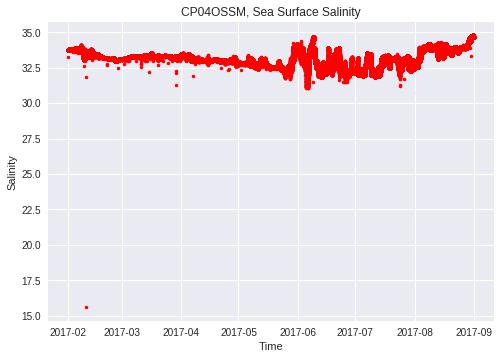

In [0]:
plt.plot(ds_ossm['time'],ds_ossm['met_salsurf'],'r.')
plt.title('CP04OSSM, Sea Surface Salinity')
plt.ylabel('Salinity')
plt.xlabel('Time')
# plt.xlim(['2017-03-01T00:00:00.000Z','2017-06-01T00:00:00.000Z'])
plt.show()

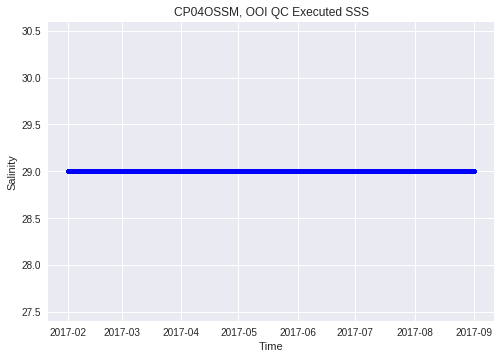

In [0]:

plt.plot(ds_ossm['time'],ds_ossm['met_salsurf_qc_executed'],'b.')

plt.title('CP04OSSM, OOI QC Executed SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.show()

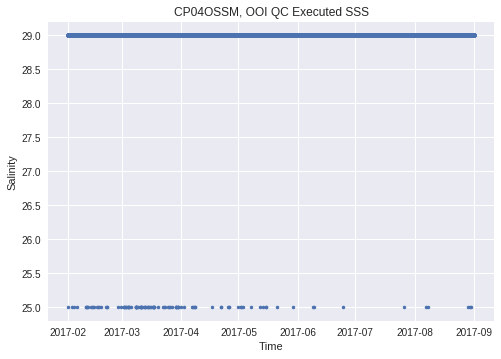

In [0]:

plt.plot(ds_ossm['time'],ds_ossm['met_salsurf_qc_results'],'.')

plt.title('CP04OSSM, OOI QC Executed SSS')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.show()

# Satellite data for peak discharge LIS
[Connecticut River Plume viewed from Satellite, 555 nm](https://drive.google.com/file/d/1WMORja_-R_cCKqvs_du7gSw5wV0vFq08/view?usp=sharing)

[2017/04/16
](https://drive.google.com/file/d/1O4Z12mJV4k3gHYuVcEIF0GzBveq-If5l/view?usp=sharing)

[2017/04/18
](https://drive.google.com/file/d/1lkwUK7yFpEioCnxHTUmkvtNQq7xRPFX_/view?usp=sharing)

[2017/05/04
](https://drive.google.com/file/d/1GNOPNc1b6YMzScnoM35x1jWTbHna7x-n/view?usp=sharing)

[2017/05/18](https://drive.google.com/file/d/1clzfsulHnVLl-dVkdP13IMdWFafjZrOb/view?usp=sharing)


Yellow shading within the Long Island Sound is the evidence of the plume in MODIS satellite color data from [NASA](https://oceancolor.gsfc.nasa.gov/cgi/browse.pl?sen=am). Downloaded the NetCDF files for days in April and May which had enough coverage (not blocked by clouds). These days are after the peack discharge: April 16, April 18, May 04, and May 18, 2017. The red box on the plots is the location of the Inshore Surface Mooring. 




# CTD at 7m on ISSM
Check data at the ISSM Near Surface Frame CTD which is at (planned) depth of 7m. Maybe this will be able to detect the plume. I think it is unlikely because the plume is probably quite thin on the shelf. 

In [0]:
site1 = 'CP03ISSM'                          # inshore surface mooring
node = 'RID27'                              # Near Surface Instrument Frame
instrument = '03-CTDBPC000'                 # CTD
method = 'recovered_inst'                   # recovered instrument
# method = 'telemetered'                     # telemtered data missing for time period wanted...

stream = 'ctdbp_cdef_instrument_recovered'  

beginDT = '2017-02-01T00:00:00.000Z'
endDT = '2017-09-01T00:00:00.000Z'
#this is all in deployment 5 

In [0]:
# Inshore Surface Mooring 
# DO NOT RERUN B/C ALREADY REQUESTED
#data_request_url ='/'.join((DATA_API,site1,node,instrument,method,stream))
#params = {
#    'beginDT':beginDT,
#    'endDT':endDT,   
#}
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()

In [0]:
#data

{u'allURLs': [u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T201333-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html',
  u'https://opendap.oceanobservatories.org/async_results/molly.james@uconn.edu/20180524T201333-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered'],
 u'numberOfSubJobs': 30,
 u'outputURL': u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T201333-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html',
 u'requestUUID': u'11b54a43-5606-44bb-9c8e-1b26f6248677',
 u'sizeCalculation': 315524,
 u'timeCalculation': 60}

In [0]:
#data['allURLs'][0]

u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T201333-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

In [0]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/molly.james@uconn.edu/20180524T201333-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets4 = [os.path.join(tds_url, i) for i in x]

ds_issm_ctd = xr.open_mfdataset(datasets4)
ds_issm_ctd = ds_issm_ctd.swap_dims({'obs': 'time'})
ds_issm_ctd


<xarray.Dataset>
Dimensions:                                  (time: 5245)
Coordinates:
    obs                                      (time) int32 0 1 2 3 4 5 6 7 8 ...
  * time                                     (time) datetime64[ns] 2017-02-01 ...
    pressure                                 (time) float64 ...
    lat                                      (time) float64 ...
    lon                                      (time) float64 ...
Data variables:
    deployment                               (time) int32 ...
    id                                       (time) |S64 ...
    conductivity                             (time) float64 ...
    ctd_time                                 (time) datetime64[ns] ...
    driver_timestamp                         (time) datetime64[ns] ...
    ingestion_timestamp                      (time) datetime64[ns] ...
    internal_timestamp                       (time) datetime64[ns] ...
    port_timestamp                           (time) datetime64[ns] ...


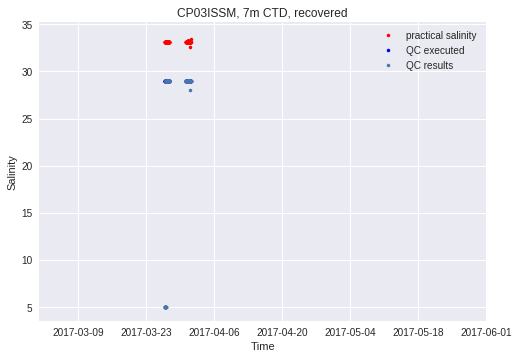

In [0]:
## plotting

plt.plot(ds_issm_ctd['time'],ds_issm_ctd['practical_salinity'],'r.',label='practical salinity')
plt.plot(ds_issm_ctd['time'],ds_issm_ctd['practical_salinity_qc_executed'],'b.',label='QC executed')
plt.plot(ds_issm_ctd['time'],ds_issm_ctd['practical_salinity_qc_results'],'.',label='QC results')

plt.title('CP03ISSM, 7m CTD, recovered')
plt.ylabel('Salinity')
plt.xlabel('Time')
plt.legend()

plt.xlim(['2017-03-01T00:00:00.000Z','2017-06-01T00:00:00.000Z'])

plt.show()
#practical_salinity
#practical_salinity_qc_executed
#practical_salinity_qc_results

The data from the CTD on the Near Surface Instrument Frame is missing for the time period of interest, April and May 2017.  Wasn't able to see if there was a freshwater signal below the surface.

# Cruise Data from Deployments
Perhaps look at the CTD casts during the cruises for deployments 5, 6, and 7 at the times closest to April and May 2017. 

* [CTD cast from Offshore, Cruise 8 Leg 1, 2017-06-01](https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/1ed1b498-7f06-4495-86b6-8098ebd8acef/3204-00802_Quick_Look_Cruise_Report_Coastal_Pioneer_8_Leg_1_2017-06-03_Ver_1-00.pdf)
* No data available for [Pioneer-07b_SI_2017-04-18](https://alfresco.oceanobservatories.org/alfresco/faces/jsp/browse/browse.jsp)

In [0]:
import pandas as pd


In [0]:
# First, specify the data file for the cruise CTD cast
# Down and Up Casts
cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/976c0631-48c8-4add-9d04-c95a066f56c4/ar18a009.asc'

# Read in the data file without headers due to a bug in the file (two of the header names run together)
cruise_data = pd.read_table(cruise_data_file, delim_whitespace=True, header=None, skiprows=1)

# Add back the necessary headers
cruise_data = cruise_data.rename(columns={0:'Pressure', 1:'Temperature', 13:'Salinity'})
cruist_data.head

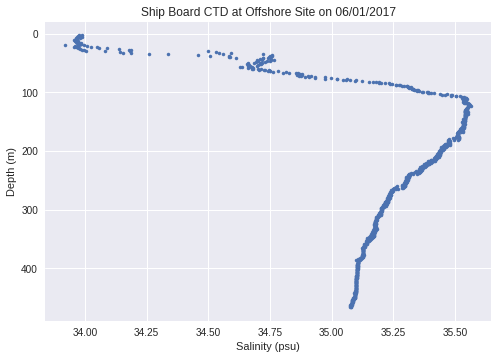

In [0]:
plt.gca().invert_yaxis()

plt.plot(cruise_data.Salinity,cruise_data.Pressure,'.')

plt.title('Ship Board CTD at Offshore Site on 06/01/2017')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')

plt.show()


# Summary
* salinity from 3 surface buoys METBK instruments
* data not available at inshore mooring for near surface CTD, 7m
* timing of peak discharge from with USGS river portal for CT River
* tracked plume with NASA MODIS ocean color
* shipboard CTD profile measurements for April/May not available at the moment


# Conclusions

* According to the buoy measurements, the Connecticut River plume for 2017 was detected by at the Inshore site, but not the Central nor Offshore sites. 
* Not sure what the OOI quality control measures are, some strange scatter in the graphs from the qc_results parameters
* Once shipboard data is available for April/May 2017 should look at it
* Once near surface CTD is available at inshore site should look at it
* Probable biofouling on the instruments, can see deployment switch in data
* Should perhaps look at the surface temperature data to see a signal as well
* More to look at!